# CLIP transfer learning
---
## Introduction

In this notebook we will look at how to fine-tune CLIP models for the [Oxford-pets](https://huggingface.co/datasets/pcuenq/oxford-pets) dataset.

[CLIP](https://arxiv.org/abs/2103.00020), or Contrastive Language-Image Pre-training, is a multimodal model that combines language and vision to extract features from text and images. The resulting features are then projected into a common Euclidean space, allowing for meaningful comparisons between text and image features using the dot product.

Normally, CLIP operates in zero-shot prediction mode or functions as a feature extractor. Consequently, fine-tuning CLIP diverges from the usual process, as seen in tasks like fine-tuning ResNet for classification. In our scenario, the model must acquire the most valuable features from both the input text and image data.

Evaluating the quality of the features extracted remains an ongoing area of active research. One method employed for this assessment involves utilizing the extracted features to address the classification problem, either through the application of a [linear classifier probe](https://h2o.ai/wiki/probing-classifiers/) or adopting a zero-shot approach.

---

Let's start with importing necessary functions, libraries and environmental variables.

In [1]:
!pip install transformers datasets evaluate peft

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 4.5 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [2]:
import os
import random
from functools import partial
from typing import Any
import evaluate
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from datasets import Dataset, DatasetDict, load_dataset
from peft import LoraConfig, get_peft_model
from PIL import Image
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
from transformers import (CLIPImageProcessor, CLIPModel, CLIPProcessor,
                          CLIPTokenizerFast, Trainer, TrainingArguments)
from transformers.tokenization_utils_base import BatchEncoding
from datasets.formatting.formatting import LazyBatch

In [3]:
os.environ["CURL_CA_BUNDLE"] = ""
os.environ["TOKENIZERS_PARALLELISM"] = "false"

def seed_all(seed: int):
    random.seed(seed)
    torch.manual_seed(seed)
    np.random.seed(seed)

seed_all(69)

### Exploratory Data Analysis on the Dataset

We'll utilize the [🤗datasets](https://huggingface.co/docs/datasets/index) library to load the [Oxford-pets](https://huggingface.co/datasets/pcuenq/oxford-pets) dataset, comprising 37 pet categories (primarily dogs and cats) with a total of 7,390 images.

Since the dataset exclusively consists of the training portion, we'll proceed to partition it into training, validation, and test sets.

In [4]:
dataset = load_dataset("StarQuestLab/oxford-iiit-pet")
dataset_train_val = dataset['train'].train_test_split(test_size=0.3)
dataset_val_test = dataset_train_val['test'].train_test_split(test_size=0.2)

dataset = DatasetDict(
    {
        "train": dataset_train_val['train'],
        "val": dataset_val_test['test'],
        "test": dataset_val_test['train']
    }
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/1.39k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/378M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/413M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/3680 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3669 [00:00<?, ? examples/s]

In [5]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label', 'class_name', 'file_name'],
        num_rows: 2576
    })
    val: Dataset({
        features: ['image', 'label', 'class_name', 'file_name'],
        num_rows: 221
    })
    test: Dataset({
        features: ['image', 'label', 'class_name', 'file_name'],
        num_rows: 883
    })
})

An individual item in the dataset consists of the following attributes:

- **path**: A string representing the image file path.
- **label**: A string denoting the pet category.
- **dog**: A boolean value; True if the image features a dog.
- **image**: A PIL image representing the dataset image.

However, for our purposes, we will exclusively utilize the **label** and **image** columns.

In [6]:
dataset['train'][0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x486>,
 'label': 20,
 'class_name': 'havanese',
 'file_name': 'havanese_185.jpg'}

Now, let's examine a selection of images along with their corresponding labels.








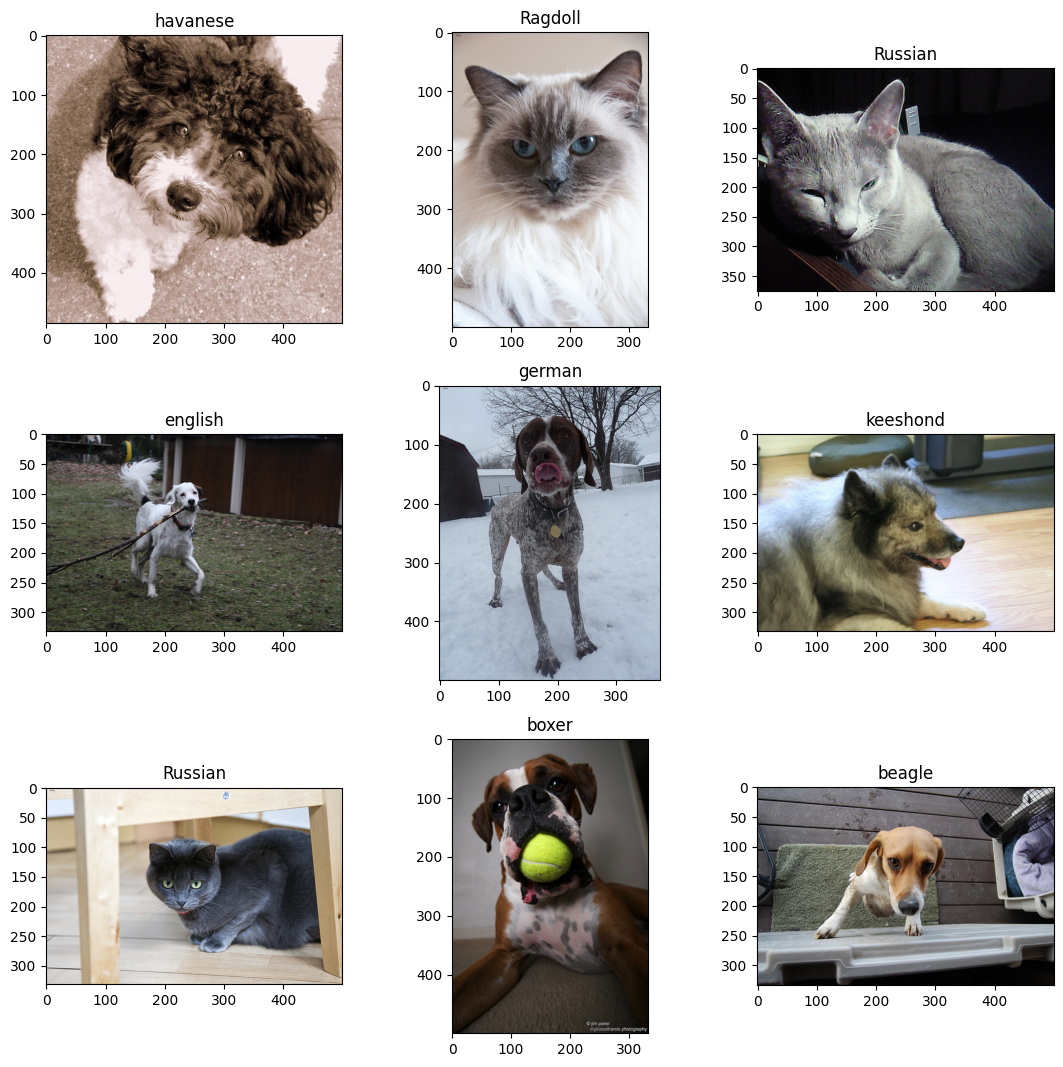

In [7]:
def show_images(ds: Dataset):
    fig, axs = plt.subplots(3, 3, figsize=(13, 13))
    for i in range(9):
        axs[i // 3][i % 3].imshow(ds[i]['image'])
        axs[i // 3][i % 3].set_title(ds[i]['class_name'])

show_images(dataset['train'])

For fine-tuning we need process labels to ids.

In [8]:
labels = set(dataset['train']['class_name'])
label2id = {label: i for i, label in enumerate(labels)}
id2label = {i: label for label, i in label2id.items()}

labels = list(label2id)

After that we get mapping from label to id.

In [9]:
label2id

{'yorkshire': 0,
 'beagle': 1,
 'Russian': 2,
 'american': 3,
 'boxer': 4,
 'Siamese': 5,
 'english': 6,
 'havanese': 7,
 'Bengal': 8,
 'pomeranian': 9,
 'samoyed': 10,
 'scottish': 11,
 'Maine': 12,
 'newfoundland': 13,
 'staffordshire': 14,
 'Egyptian': 15,
 'basset': 16,
 'Birman': 17,
 'great': 18,
 'wheaten': 19,
 'Bombay': 20,
 'japanese': 21,
 'saint': 22,
 'Sphynx': 23,
 'keeshond': 24,
 'Abyssinian': 25,
 'german': 26,
 'Persian': 27,
 'Ragdoll': 28,
 'pug': 29,
 'chihuahua': 30,
 'leonberger': 31,
 'British': 32,
 'shiba': 33,
 'miniature': 34}

### Dataset preparation

For the default CLIP model, we will use the pre-trained [model by OpenAI](https://huggingface.co/openai/clip-vit-base-patch32). However, feel free to modify the `MODEL_NAME` variable to another model. For instance [this](https://huggingface.co/openai/clip-vit-large-patch14) model of CLIP have a larger number of parameters.

In [10]:
MODEL_NAME = "openai/clip-vit-base-patch32"

For selected `MODEL_NAME` we need to import corresponding:
- **Tokenizer**: used to encode input text.
- **Image processor**: It is utilized to preprocess input images, handling tasks such as scaling, resizing, and more.

In [11]:
TOKENIZER = CLIPTokenizerFast.from_pretrained(MODEL_NAME)
IMAGE_PROCESSOR = CLIPImageProcessor.from_pretrained(MODEL_NAME)

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

Dataset preparation consists of 2 steps
1) **Label Encoding with Tokenizer**: This step entails encoding the label of each dataset item using the tokenizer. Importantly, we encode not only the label's text but also include a special prompt with the label. This enhancement is designed to elevate the quality of text features in the language model.

2) **Image Preparations with CLIP's Image Processor**: In this step, we prepare the images using CLIP's image processor. This involves preprocessing steps to ensure compatibility with CLIP's model architecture.

In [12]:
def transform_class_labels(
    items: LazyBatch, tokenizer: CLIPTokenizerFast, label2id: dict[str, int]
) -> dict[str, Any]:
    """Function used to encode item's label prompt with tokenizer

    Args:
        items (LazyBatch): Input dataset items
        tokenizer (CLIPTokenizerFast): CLIP's tokenizer
        label2id (dict[str, int]): mapping from label to id

    Returns:
        dict[str, Any]: transformed items
    """
    # this prompt is better than prompt consisting only of the class name
    label_prompt = [f"a photo of {label}" for label in items["class_name"]]
    output = tokenizer(label_prompt, padding=True, return_tensors="pt")
    items["input_ids"] = output["input_ids"]
    items["attention_mask"] = output["attention_mask"]
    items["label_id"] = [label2id[label] for label in items["class_name"]]
    return items


def transform_image(items: LazyBatch, image_processor: CLIPImageProcessor) -> dict[str, Any]:
    """Function used to preprocess input image with image processor

    Args:
        items (LazyBatch): Input dataset items
        image_processor (CLIPImageProcessor): CLIP's image processor

    Returns:
        dict[str, Any]: transformed items
    """
    output = image_processor(items["image"], return_tensors="pt")
    items["pixel_values"] = output["pixel_values"]
    return items

We can efficiently apply `transform_class_labels` function on each dataset split with [map function](https://huggingface.co/docs/datasets/process#map) inplace.

But for `transform_image` function we'll use [set_transform](https://huggingface.co/docs/datasets/v2.16.1/en/package_reference/main_classes#datasets.Dataset.set_transform) to lazily process pictures because it's inefficient to store them in memory

In [13]:
dataset = dataset.map(partial(transform_class_labels, tokenizer=TOKENIZER, label2id=label2id), batched=True)
dataset.set_transform(partial(transform_image, image_processor=IMAGE_PROCESSOR))

Map:   0%|          | 0/2576 [00:00<?, ? examples/s]

Map:   0%|          | 0/221 [00:00<?, ? examples/s]

Map:   0%|          | 0/883 [00:00<?, ? examples/s]

### CLIP Image Classification

In [14]:
# utilities functions
def get_module_device(module: nn.Module) -> torch.device:
    """Function to get current module device

    Args:
        module (nn.Module): pytorch module

    Returns:
        torch.device: module's device
    """
    return next(module.parameters()).device


def freeze_params(module: nn.Module, freeze_top_percent: float = 1.0) -> None:
    """Function used to freeze module by setting 'requires_grad' to False

    Args:
        module (nn.Module): pytorch module
        freeze_top_percent (float, optional): percentage of layers starting from the top that need to be frozen. Defaults to 1.0.
    """
    all_params_length = len(list(module.parameters()))
    for indx, param in enumerate(module.parameters()):
        if int(all_params_length * freeze_top_percent) <= indx:
            break
        param.requires_grad = False


def print_trainable_parameters(model: nn.Module) -> None:
    """Function prints statistics about trainable parameters

    Args:
        model (nn.Module): pytorch module
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"Trainable params: {(trainable_params / 10**6):.4f}M || All params: {(all_param / 10**6):.4f}M || Trainable%: {100 * trainable_params / all_param:.2f}%"
    )

Our CLIP based classification model will work as follows:
1. **Prompt Generation**: Initial prompts are generated based on the labels present in the dataset.
2. **Feature Extraction with Language CLIP Model**: Features are extracted from these prompts using a language CLIP model.
3. **Visual Feature Extraction**: For each image, features are extracted using a visual CLIP model.
4. **Similarity Score Computation**: A similarity score between the image and the set of prompts is computed.
5. **Prediction Based on Similarity**: The most similar prompt is selected, and its associated label is used as the final prediction for the image.

In [15]:
class CLIPClassifier(nn.Module):
    def __init__(self, clip_model: CLIPModel, tokenizer: CLIPTokenizerFast, labels: list[str]):
        super().__init__()
        self.model = clip_model
        self.tokenizer = tokenizer
        self.logit_scale = self.model.logit_scale.exp()
        self.label2id = {label: i for i, label in enumerate(labels)}
        self.labels_embeddings = nn.Parameter(self.generate_labels_embeddings(labels))

    def generate_labels_embeddings(self, labels: list[str]) -> torch.Tensor:
        """Function prepares label's prompt embeddings usings language model

        Args:
            labels (list[str]): list with dataset labels

        Returns:
            torch.Tensor: labels embeddings of size (num_labels, dim)
        """
        # tokenize label's prompt
        labels_inputs = self.tokenizer(
            [f"a photo of {label}" for label in labels],
            return_tensors="pt",
            padding=True,
        ).to(get_module_device(self.model))
        # run language model on this prompt and get embeddings
        labels_embeddings = self.model.get_text_features(**labels_inputs)
        # normilize embeddings
        labels_embeddings /= labels_embeddings.norm(p=2, dim=-1, keepdim=True)
        return labels_embeddings

    def forward(self, images: torch.Tensor) -> torch.Tensor:
        """Function to calculate similarity between image and label's promts embeddings

        Args:
            images (torch.Tensor): image tensor

        Returns:
            torch.Tensor: output similarity tensor of size (batch_size,  num_labels)
        """
        image_features = self.model.get_image_features(
            images
        )  # (batch_size, dim)
        image_features /= image_features.norm(p=2, dim=-1, keepdim=True)
        return torch.matmul(image_features, self.labels_embeddings.T) * self.logit_scale

def calculate_accuracy(model: CLIPClassifier, dataloader: DataLoader) -> float:
    """Function calculates accuracy of given model on dataloader

    Args:
        model (CLIPClassifier): CLIP classifier model
        dataloader (DataLoader): evaluation dataloader

    Returns:
        float: model's accuracy
    """
    metric = evaluate.load("accuracy")
    predictions_list = []
    references_list = []
    device = get_module_device(model)
    for batch in tqdm(
        dataloader, total=len(dataloader), desc="Evaluate model on dataset"
    ):
        batch["pixel_values"] = batch["pixel_values"].to(device)
        predictions = model(batch["pixel_values"])
        predictions_list.append(torch.argmax(predictions, dim=1))
        references_list.append(batch["label_id"])
    return metric.compute(
        predictions=torch.concat(predictions_list),
        references=torch.concat(references_list),
    )["accuracy"]

def collate_fn(items: LazyBatch) -> dict[str, Any]:
    return {
        "pixel_values": torch.stack(
            [item["pixel_values"] for item in items]
        ),  # (batch_size, 3, 224, 224)
        "input_ids": torch.tensor(
            [item["input_ids"] for item in items]
        ),  # (batch_size, max_length)
        "attention_mask": torch.tensor(
            [item["attention_mask"] for item in items]
        ),  # (batch_size, max_length)
        "label_id": torch.tensor([item["label_id"] for item in items]),  # (batch_size),
        "return_loss": True,
    }

@torch.no_grad()
def evaluate_clip_classifier(
    model: nn.Module,
    dataset: Dataset,
    tokenizer: CLIPTokenizerFast,
    labels: list[str],
    batch_size: int = 64,
    num_workers: int = 5,
    device: str = "cuda",
) -> None:
    """Function evaluates CLIP model on given dataset

    Args:
        model (nn.Module): CLIP model
        dataset (Dataset): evaluation dataset
        tokenizer (CLIPTokenizerFast): CLIP tokenizer
        labels (list[str]): list with dataset labels
        batch_size (int): batch size. Defaults to 64
        num_workers (int): number of workers for dataloader. Defaults to 5
        device (str, optional): model's device. Defaults to "cuda".
    """
    clip_classifier = CLIPClassifier(model, tokenizer, labels)
    test_dataloader = DataLoader(
        dataset, batch_size=batch_size, num_workers=num_workers, collate_fn=collate_fn
    )
    clip_classifier = clip_classifier.to(device)
    acc = calculate_accuracy(clip_classifier, test_dataloader)
    print(f"Model accuracy: {acc}")

### Evaluate baseline CLIP (Zero-shot)

First, let's evaluate our pretrained CLIP model on test dataset. One of the advantages of CLIP model compared to standard classification models is that it works well without fine-tuning.

In [16]:
clip_baseline = CLIPModel.from_pretrained(MODEL_NAME)
freeze_params(clip_baseline)
print_trainable_parameters(clip_baseline)
evaluate_clip_classifier(clip_baseline, dataset['test'], TOKENIZER, labels)

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

Trainable params: 0.0000M || All params: 151.2773M || Trainable%: 0.00%


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Evaluate model on dataset:   0%|          | 0/14 [00:00<?, ?it/s]

Model accuracy: 0.42808607021517553


In our case we got 0.8 accuracy for free! But we can improve it even further our metrics with fine-tuning techniques.

## Fine-tuning

In this section, we'll undertake the fine-tuning process leveraging the [🤗HuggingFace Trainer API](https://huggingface.co/docs/transformers/main_classes/trainer). The Trainer API significantly streamlines the training code, eliminating much of the boilerplate, and offers various features such as the ability to save model weights and training in fp16.

In [17]:
def collate_train_fn(items: LazyBatch):
    items = collate_fn(items)
    items.pop("label_id")
    return items


def get_default_training_args(
    experiment_name: str,
    lr: float,
    batch_size: int = 256,
    num_epoch: int = 2,
    num_workers: int = 15,
) -> TrainingArguments:
    """Function gets default training arguments for HF Trainer

    Args:
        experiment_name (str): experiment name
        lr (float): learning rate
        batch_size (int, optional): batch size. Defaults to 256.
        num_epoch (int, optional): number of epoch to train. Defaults to 2.
        num_workers (int, optional): number of workers for dataloader. Defaults to 15.

    Returns:
        TrainingArguments: arguments object for HF Trainer
    """
    return TrainingArguments(
        experiment_name,
        per_device_train_batch_size=batch_size,
        learning_rate=lr,
        num_train_epochs=num_epoch,
        per_device_eval_batch_size=batch_size,
        gradient_accumulation_steps=1,
        logging_steps=10,
        save_total_limit=2,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        fp16=True,
        remove_unused_columns=False,
        load_best_model_at_end=True,
        dataloader_num_workers=num_workers,
    )

### All layers tuning

Initially, let's explore the simplest approach to fine-tuning, which involves fine-tuning all layers of the model. While straightforward, it's important to note that this method is computationally intensive.

In [18]:
clip_full_finetuned = CLIPModel.from_pretrained(MODEL_NAME)
trainer = Trainer(
    model=clip_full_finetuned,
    args=get_default_training_args("clip-all-layers-tuning-oxford-pets", 3e-6),
    data_collator=collate_train_fn,
    train_dataset=dataset["train"],
    eval_dataset=dataset["val"],
)

trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 15 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more in

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 15 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,4.346300,3.176693
2,2.926200,2.794830


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 15 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 15 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


TrainOutput(global_step=22, training_loss=3.4665673212571577, metrics={'train_runtime': 279.4747, 'train_samples_per_second': 18.435, 'train_steps_per_second': 0.079, 'total_flos': 31135207638528.0, 'train_loss': 3.4665673212571577, 'epoch': 2.0})

In [19]:
print_trainable_parameters(clip_full_finetuned)
evaluate_clip_classifier(clip_full_finetuned, dataset['test'], TOKENIZER, labels)

Trainable params: 151.2773M || All params: 151.2773M || Trainable%: 100.00%


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Evaluate model on dataset:   0%|          | 0/14 [00:00<?, ?it/s]

Model accuracy: 0.7701019252548131


### Fine-tuning Text Encoder

Following that, we have the option to fine-tune only the language model while keeping the visual model weights frozen. This method proves beneficial when dataset labels are provided in a language that differs from the one in which the language model was originally trained.

In [20]:
clip_text_model_tuning = CLIPModel.from_pretrained(MODEL_NAME)
freeze_params(clip_text_model_tuning.vision_model)

trainer = Trainer(
    model=clip_text_model_tuning,
    args=get_default_training_args("clip-text-model-tuning-oxford-pets", 3e-5),
    data_collator=collate_train_fn,
    train_dataset=dataset["train"],
    eval_dataset=dataset["val"],
)

trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 15 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,3.915300,2.529121
2,2.344800,2.345053


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 15 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 15 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


TrainOutput(global_step=22, training_loss=2.964631676673889, metrics={'train_runtime': 173.5914, 'train_samples_per_second': 29.679, 'train_steps_per_second': 0.127, 'total_flos': 31135207638528.0, 'train_loss': 2.964631676673889, 'epoch': 2.0})

In [21]:
print_trainable_parameters(clip_text_model_tuning)
evaluate_clip_classifier(clip_text_model_tuning, dataset['test'], TOKENIZER, labels)

Trainable params: 63.8213M || All params: 151.2773M || Trainable%: 42.19%


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Evaluate model on dataset:   0%|          | 0/14 [00:00<?, ?it/s]

Model accuracy: 0.912797281993205


### Fine-tuning Image Encoder

We can do the opposite and fine-tune only vision model. This can be useful if the image domain in your dataset is quite specific, such as satellite images

In [22]:
clip_vision_model_tuning = CLIPModel.from_pretrained(MODEL_NAME)
freeze_params(clip_vision_model_tuning.text_model)

trainer = Trainer(
    model=clip_vision_model_tuning,
    args=get_default_training_args("clip-vision-model-tuning-oxford-pets", 3e-5),
    data_collator=collate_train_fn,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
)

trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 15 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,4.091700,2.937852
2,2.404400,2.494642


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 15 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 15 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


TrainOutput(global_step=22, training_loss=3.0733742930672387, metrics={'train_runtime': 164.5809, 'train_samples_per_second': 31.304, 'train_steps_per_second': 0.134, 'total_flos': 31135207638528.0, 'train_loss': 3.0733742930672387, 'epoch': 2.0})

In [23]:
print_trainable_parameters(clip_vision_model_tuning)
evaluate_clip_classifier(clip_vision_model_tuning, dataset['test'], TOKENIZER, labels)

Trainable params: 88.1114M || All params: 151.2773M || Trainable%: 58.24%


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Evaluate model on dataset:   0%|          | 0/14 [00:00<?, ?it/s]

Model accuracy: 0.8629671574178935


### Fine-tune 30 percent of the Last Layers of Vision-Language Model

The most universal option is to fine-tune only the last layers in both models. This approach strikes a balance, allowing adaptation to the specific task while leveraging the pre-trained knowledge from the lower layers.

In [24]:
clip_partial_tuning = CLIPModel.from_pretrained(MODEL_NAME)
freeze_params(clip_partial_tuning.text_model, freeze_top_percent=0.7)
freeze_params(clip_partial_tuning.vision_model, freeze_top_percent=0.7)

In [25]:
trainer = Trainer(
    model=clip_partial_tuning,
    args=get_default_training_args("clip-partial-model-tuning-oxford-pets", 3e-5),
    data_collator=collate_train_fn,
    train_dataset=dataset["train"],
    eval_dataset=dataset["val"],
)

trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 15 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,3.925900,2.447874
2,2.251300,2.312449


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 15 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 15 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


TrainOutput(global_step=22, training_loss=2.922670776193792, metrics={'train_runtime': 128.0344, 'train_samples_per_second': 40.239, 'train_steps_per_second': 0.172, 'total_flos': 31135207638528.0, 'train_loss': 2.922670776193792, 'epoch': 2.0})

In [26]:
print_trainable_parameters(clip_partial_tuning)
evaluate_clip_classifier(clip_partial_tuning, dataset['test'], TOKENIZER, labels)

Trainable params: 38.7971M || All params: 151.2773M || Trainable%: 25.65%


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Evaluate model on dataset:   0%|          | 0/14 [00:00<?, ?it/s]

Model accuracy: 0.9093997734994338


### PEFT tuning (with LoRA)

In cases where you want to fine-tune a pre-trained model with a large number of parameters, you can use the [PEFT](https://huggingface.co/blog/peft)(Parameter-Efficient Fine-Tuning) techniques. PEFT allows you to train a small number of parameters (about 1-5% of all model parameters) with performance comparable to training all layers

In our case, we will use the [LoRA](https://huggingface.co/docs/peft/conceptual_guides/lora) technique using the [🤗HuggingFace PEFT](https://huggingface.co/docs/peft/index) library.

**LoRA** introduces two small-rank matrices (called *update matrices*) to the initial weights of the pretrained model. Throughout the fine-tuning process, the initial weights of the model remain frozen, and only the update matrices are trained.

In our specific case, we'll employ update matrices of rank 64, applied to the query, key, and value matrices in both the visual and language components of the CLIP model.

In [27]:
clip_lora_tuning = CLIPModel.from_pretrained(MODEL_NAME)
config = LoraConfig(
    r=64,
    lora_alpha=64,
    target_modules=['q_proj', 'k_proj', 'v_proj'],
)

lora_model = get_peft_model(clip_lora_tuning, config)

In [28]:
trainer = Trainer(
    model=lora_model,
    args=get_default_training_args("clip-lora-model-tuning-oxford-pets", 3e-4),
    data_collator=collate_train_fn,
    train_dataset=dataset["train"],
    eval_dataset=dataset["val"],
)

trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 15 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,3.824000,2.811716
2,2.531300,2.481640


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 15 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 15 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


TrainOutput(global_step=22, training_loss=3.0187463760375977, metrics={'train_runtime': 105.2673, 'train_samples_per_second': 48.942, 'train_steps_per_second': 0.209, 'total_flos': 32593818797568.0, 'train_loss': 3.0187463760375977, 'epoch': 2.0})

In [29]:
print_trainable_parameters(lora_model)
evaluate_clip_classifier(lora_model, dataset['test'], TOKENIZER, labels)

Trainable params: 5.8982M || All params: 157.1756M || Trainable%: 3.75%


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Evaluate model on dataset:   0%|          | 0/14 [00:00<?, ?it/s]

Model accuracy: 0.869762174405436


## Conclusion

In this notebook, we explored the fine-tuning of a CLIP model on the Oxford-pets dataset, assessing the model's performance in zero-shot mode and through various fine-tuning methods, including PEFT.

The achieved results are summarized below:

| Model                       | Trainable Parameters (M) |  Trainable Parameters (%) | Accuracy    |
| --------------------------- | ------------------------ | ------------------------- | ----------- |
| Baseline (Zero-shot)        | 0                        | 0%                        | 0.4281
     |
| Full fine-tuning            | 151.28                   | 100%                      | 0.7701      |
| Only language model tuning  | 63.82                    | 42.19%                    | **0.9128**      |
| Only vision model tuning    | 88.11                    | 58.24%                    | 0.8630      |
|Top 30% of both models tuning| 38.79                    | 25.65%                    | 0.9094  |  
| LoRA tuning                 | **5.90**                 | **3.75%**                 | 0.8698     |

In our case, the best result was obtained from the model with fine-tuning only top 30% of layers.

Feel free to experiment with training parameters in the Trainer and CLIP model settings to potentially enhance the results further!